# Generating training data from manual annotations

If you wish to train HoverFast to segment other round-like objects or wish to provide nuclei annotations that do not come from HoverNet, you can do so!
This tutorial provides a way to convert a directory of .png files and corresponding .geojson annotations into a training and testing set compatible with HoverFast.
To create annotations, you can generate tissue tiles at your desired size and magnification. Then, import them on QuPath and draw your annotations. Then you can go to File > Export Objects as geojSON. Then select All objects, Pretty JSON and Export as FeatureCollection.

**This tutorial assumes that you have a directory of .png files (tile_1.png, tile_2.png, etc...) and the corresponding geojson files with your annotations (tile_1.geojson, tile_2.geojon, etc...). Also, all tiles should have the same size.**

In [13]:
import tables
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
import json
import glob
from tqdm.autonotebook import tqdm
import random
from sklearn.model_selection import train_test_split

# Parameters
Here we provide the tile size and the path to the tiles in .png format. Note that the geojson files should have the same filename but with the .geojson extension

In [7]:
tile_size = 1024
path_to_tiles_pattern = glob.glob("tests/data/*tile*.png")
path_to_geojsons = "tests/data/"
output_dir = 'my_training_data_hoverfast'

# Utility functions

These functions convert the geojson annotations to a mask and generate the pytables file

In [2]:
def make_label(fname, shape, dtype=np.int32):
    """Creates binary and labeled masks using the json annotation file and patch shape."""
    with open(fname, 'r') as json_file:
        data = json.load(json_file)
        features = data["features"]

    label = np.zeros(shape, dtype)

    for ind, feature in enumerate(features):
        geometry_type = feature["geometry"]["type"]
        
        if geometry_type != "Polygon":
            # Skip any geometry that is not a Polygon
            continue

        coordinates = feature["geometry"]["coordinates"]

        # Handle each ring (external and any internal ones) separately
        for ring in coordinates:
            polygon = np.array(ring, dtype=np.int32)
            cv2.fillPoly(label, [polygon], ind + 1)

    return label

In [29]:
def create_pytables(output_dir, png_files, geojson_dir, train_size=0.8, tile_size=256, classes=[1]):
    # Derive the corresponding geojson files
    json_files = [os.path.join(geojson_dir, os.path.basename(png_file).replace('.png', '.geojson')) for png_file in png_files]

    # Split files into training and testing
    json_train, json_test, png_train, png_test = train_test_split(json_files, png_files, train_size=train_size, random_state=42)

    # Prepare PyTables files for training and testing
    filters = tables.Filters(complevel=6, complib='zlib')
    hdf5_train = tables.open_file(os.path.join(output_dir, 'data_train.pytable'), mode='w', filters=filters)
    hdf5_test = tables.open_file(os.path.join(output_dir, 'data_test.pytable'), mode='w', filters=filters)

    def initialize_storage(hdf5_file, num_samples):
        storage = {}
        block_shape = {
            "img": np.array((tile_size, tile_size, 3)),
            "mask": np.array((tile_size, tile_size)),
            "label": np.array((tile_size, tile_size)),
        }
        imgtypes = ["img", "mask", "label"]
        img_dtype = {
            "img": tables.UInt8Atom(),
            "mask": tables.UInt8Atom(),
            "label": tables.Int16Atom(),
        }

        for imgtype in imgtypes:
            storage[imgtype] = hdf5_file.create_earray(hdf5_file.root, imgtype, 
                                                       img_dtype[imgtype], 
                                                       shape=(0,) + tuple(block_shape[imgtype]), 
                                                       chunkshape=(1,) + tuple(block_shape[imgtype]))
        return storage

    storage_train = initialize_storage(hdf5_train, len(json_train))
    storage_test = initialize_storage(hdf5_test, len(json_test))

    def process_files(json_files, png_files, storage, totals):
        for json_file, png_file in zip(json_files, png_files):
            label = make_label(json_file, (tile_size, tile_size))
            mask = (label > 0).astype(np.uint8)
            img = cv2.imread(png_file)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            storage["mask"].append(mask[np.newaxis])
            storage["label"].append(label[np.newaxis])
            storage["img"].append(img[np.newaxis])

            for i, key in enumerate(classes):
                totals[1, i] += np.sum(mask == key)

    totals_train = np.zeros((2, len(classes)), dtype=np.int32)
    totals_test = np.zeros((2, len(classes)), dtype=np.int32)

    # Process training and testing sets
    process_files(json_train, png_train, storage_train, totals_train)
    process_files(json_test, png_test, storage_test, totals_test)

    # Store the number of pixels for each class in the training and testing datasets
    hdf5_train.create_carray(hdf5_train.root, 'numpixels', tables.Atom.from_dtype(totals_train.dtype), totals_train.shape)[:]=totals_train
    hdf5_test.create_carray(hdf5_test.root, 'numpixels', tables.Atom.from_dtype(totals_test.dtype), totals_test.shape)[:]=totals_test

    # Close the HDF5 files
    hdf5_train.close()
    hdf5_test.close()

# Create pytables

This function will create the two pytables (one for training one for testing)

In [30]:
create_pytables(output_dir, path_to_tiles_pattern, path_to_geojsons, train_size=0.8, tile_size=1024, classes=[0, 1])

# Inspecting generated datasets

Here we visualize some examples from the generated pytables to ensure that everything looks in order

In [16]:
h5_train = tables.open_file("data_train.pytable") #read your dataset

In [25]:
def plot_images_side_by_side(rgb_patch, binary_mask, labeled_mask, figsize=(15, 5), cmap='gray'):
    """
    Plots three images side by side: an RGB patch, a binary mask, and a labeled mask.

    Parameters:
        rgb_patch (numpy.ndarray): The RGB image patch to display.
        binary_mask (numpy.ndarray): The binary mask image to display.
        labeled_mask (numpy.ndarray): The labeled mask image to display.
        figsize (tuple): The size of the figure (width, height).
        cmap (str): The colormap to use for displaying the binary and labeled masks.
    """
    fig, axes = plt.subplots(1, 3, figsize=figsize)

    # Plot RGB image patch
    axes[0].imshow(rgb_patch)
    axes[0].set_title("RGB Patch")
    axes[0].axis('off')

    # Plot binary mask
    axes[1].imshow(binary_mask, cmap=cmap)
    axes[1].set_title("Binary Mask")
    axes[1].axis('off')

    # Plot labeled mask
    axes[2].imshow(labeled_mask)
    axes[2].set_title("Labeled Mask")
    axes[2].axis('off')

    # Show the plot
    plt.show()

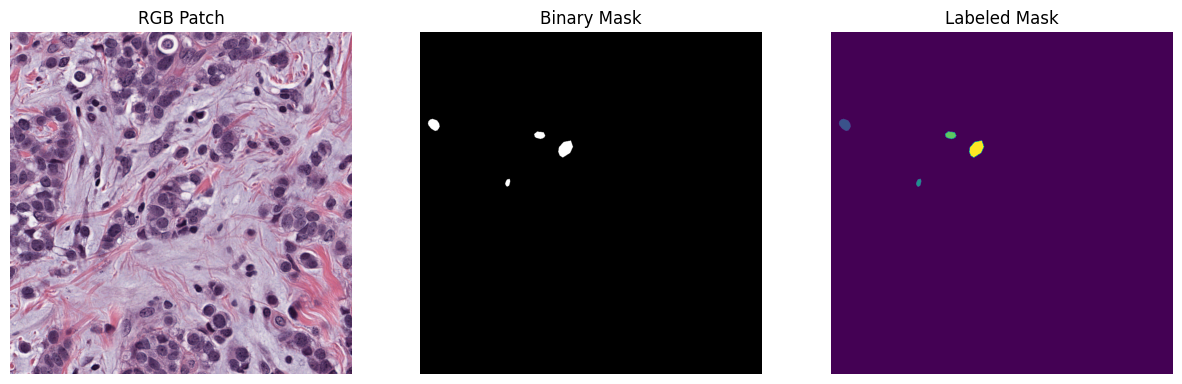

In [26]:
plot_images_side_by_side(h5_train.root.img[0], h5_train.root.mask[0], h5_train.root.label[0]) 